In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import torch_geometric as pyg
import networkx as nx
import numpy as np
import pandas as pd
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform

from mil.data.mnist import Bag, MNISTBags, OneHotMNISTBags, MNISTCollage, OneHotMNISTCollage
from mil.utils import device, detach, human_format
from mil.models import MILModel
from mil.utils.visualize import print_one_hot_bag_with_attention, print_one_hot_bag, plot_attention_head, plot_bag, plot_one_hot_collage
from mil.utils.stats import print_prediction_stats
from mil.models.attention import WeightedAverageAttention, MultiHeadAttention
from mil.models.set_transformer import SetTransformer, InducedSetTransformer, SAB, ISAB

/Users/georg/Projects/mil/mil_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MNIST bags / MNIST collage

This notebook trains models on variations of the *mnist-bags*, *multi-mnist-bags*, and *mnist-collage* datasets. 
The goal of this notebook is to see which models are able to overfit on these datasets.


The following cell defines three variables, `DATASET`, `TARGET_NUMBERS` and `MODEL` which can be used to run different dataset/model configurations.

`DATASET`:
- `OneHotMNISTBags`: one-hot version of *mnist-bags*, where the dataset yields 10-dimensional one-hot encoded feature vectors directly (i.e. we are not yet working with MNIST digits)
- `MNISTBags`: the *mnist-bags* dataset
- `OneHotMNISTCollage`: one-hot version of *mnist-collage*
- `MNISTCollage`: *mnist-collage* dataset

`TARGET_NUMBERS`:
- `0` corresponds to the *mnist-bags* dataset
- `(0, 1)` corresponds to the *multi-mnist-bags* dataset

`MODELS`:
- `"mean_pool"`: simple baseline that uses mean pooling. Works neither dataset.
- `"max_pool"`: simple baseline that uses max pooling. Works for *mnist-bags*, but not *multi-mnist-bags*.
- `"weighted_average_attention"`: uses attention mechanism from "Attention Based Deep Multiple Instance Learning" paper which can only "focus" on one target number at a time. Works for *mnist-bags*, but not *multi-mnist-bags*.
- `"self_attention_mean_pooling"`: uses a single transformer layer (self attention) followed by mean pooling. Works for both datasets.
- `"self_attention_max_pooling"`: uses a single transformer layer (self attention) followed by max pooling. Works for both datasets (but better than mean pooling).


Try changing `DATASET`, `TARGET_NUMBERS` and `MODELS` below and rerunning the notebook.

In [2]:
# DATASET = OneHotMNISTBags
# DATASET = MNISTBags
DATASET = OneHotMNISTCollage
# DATASET = MNISTCollage

# TARGET_NUMBERS = (0)
TARGET_NUMBERS = (0, 1)

# MODEL = "mean_pool"
# MODEL = "max_pool"
# MODEL = "weighted_average_attention"
# MODEL = "self_attention_mean_pool"
MODEL = "self_attention_max_pool"
MODEL = "distance_aware_attention_max_pool"
# MODEL = "set_transformer"
# MODEL = "induced_set_transformer"
# MODEL = "sab_max_pool"
# MODEL = "isab_max_pool"
# MODEL = "gcn_max_pool"
# MODEL = "dense_gcn_max_pool"
# MODEL = "gat_max_pool"

# Only for collages
COLLAGE_SIZE = 256
MIN_DIST = 20

NUM_DIGITS = 10
if DATASET.__name__.startswith("OneHot"):
    FEATURE_SIZE = NUM_DIGITS # must be NUM_DIGITS due to one-hot encoding
    HIDDEN_DIM = 10
else:
    FEATURE_SIZE = 64
    HIDDEN_DIM = 10

In [3]:
def make_data_loader(train: bool = True):
    """Utility function to create a data loader for the dataset."""
    extra_kwargs = {}
    if "Collage" in DATASET.__name__:
        extra_kwargs["collage_size"] = COLLAGE_SIZE
        extra_kwargs["min_dist"] = MIN_DIST
    ds = DATASET(target_numbers=TARGET_NUMBERS, # target number
                 num_digits=NUM_DIGITS, # sample from all 10 MNIST digits
                 mean_bag_size=10, # mean bag length
                 var_bag_size=2, # variance of bag length
                 num_bags=250 if train else 100, # number of bags
                 seed=1,
                 train=train,
                 **extra_kwargs)
    loader = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=train, collate_fn=lambda x: x[0])
    return loader

## Define the model

The three parts of the MIL model are:
1. **feature extractor**: extract a feature vector $z \in \mathbb{R}^D$ from each instance. In the case of the one-hot dataset, this is just the identity function. For the actual *mnist-bags* dataset, this is a CNN.
2. **pooling**: a function $f : \mathbb{R}^{N \times D} \to \mathbb{R}^D$ that aggregates the $N$ feature vectors in the bag to a single feature vector.
3. **classifier**: a function $g : \mathbb{R}^D \to \mathbb{R}$ that transforms the aggregated feature vector into a binary classification prediction (we parameterise $g$ using a linear layer followed by a sigmoid)


In [4]:
class OneHotFeatureExtractor(nn.Module):
    def forward(self, bag: Bag):
        # In the case of OneHotBags, the instances are already the features.
        return bag.instances

class CNNFeatureExtractor(nn.Module):
    def __init__(self, feature_size: int):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(.1),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Flatten(-3, -1),
            nn.Dropout(.2),
            nn.Linear(20 * 4 * 4, feature_size),
            nn.ReLU()
        )

    def forward(self, bag: Bag):
        return self.cnn(bag.instances)

class GNN(nn.Module):
    """GNN model.
    
    The layer parameter can be used to specify the type of GNN layer to use (e.g. pyg.nn.GCNConv, pyg.nn.GATConv, pyg.nn.DenseGCNConv).
    """

    def __init__(self, feature_size: int, hidden_dim: int, layer=pyg.nn.GCNConv):
        super().__init__()
        self.layer = layer
        self.gnn = pyg.nn.Sequential('x, connectivity', [
            (layer(feature_size, hidden_dim), 'x, connectivity -> x'),
            nn.ReLU(inplace=True),
            (layer(hidden_dim, feature_size), 'x, connectivity -> x'),
            nn.ReLU(inplace=True),
        ])

    def forward(self, bag, features):
        number_of_nodes = features.shape[0]
        
        # Assume complete graph
        edge_index = np.array(nx.complete_graph(number_of_nodes).edges).T # complete (directed) graph
        edge_index = np.concatenate([edge_index, edge_index[::-1]], axis=-1) # undirected graph

        # Use distance-based edge weights (distance-based) to drop out edges
        instance_locations = bag.instance_locations
        if instance_locations is not None:
            edge_weights = []
            for i, (n1, n2) in enumerate(zip(edge_index[0], edge_index[1])):
                eucl_dist = np.linalg.norm(n2 - n1)
                edge_weights.append(eucl_dist)

            # normalise
            print(edge_weights)
            edge_weights = np.array(edge_weights)
            scaler = preprocessing.MinMaxScaler()
            edge_weights = scaler.fit_transform(edge_weights.reshape(-1, 1)).reshape(1, -1)[0]
            print("Normalized ", edge_weights)

            # drop-out edge based on edge weights
            print(edge_index)
            tau = 0.5
            ei_1 = edge_index[0][(edge_weights < tau)]
            ei_2 = edge_index[1][(edge_weights < tau)]
            edge_index = np.array([ei_1, ei_2])

        if self.layer == pyg.nn.DenseGCNConv:
            # DenseGCNConv requires a dense adjacency matrix
            adj = np.zeros((number_of_nodes, number_of_nodes))
            for n1, n2 in zip(edge_index[0], edge_index[1]):
                adj[n1][n2] = 1
            
            connectivity = torch.from_numpy(adj)
        else:
            edge_index = torch.from_numpy(edge_index)
            connectivity = edge_index
 
        batch = torch.tensor([0] * number_of_nodes)
        x = self.gnn(features, connectivity)
        x = pyg.nn.global_max_pool(x, batch)
        return x

class DistanceKV(nn.Module):
    def __init__(self, feature_size: int, hidden_dim: int, bias: bool = True):
        super().__init__()
        self.keys = nn.Linear(feature_size, hidden_dim, bias=bias)
        self.queries = nn.Linear(feature_size, hidden_dim, bias=bias)
        self.relu = nn.ReLU()
        # self.relu = nn.LeakyReLU(.1)
    
    def forward(self, features):
        k = self.keys(features)
        q = self.queries(features)
        D = q @ k.transpose(-2, -1)
        D = self.relu(D)
        return D

class DistanceAwareAttentionHead(nn.Module):
    def __init__(self, feature_size: int, hidden_dim: int):
        super().__init__()
        self.keys = nn.Linear(feature_size, hidden_dim, bias=False)
        self.queries = nn.Linear(feature_size, hidden_dim, bias=False)
        self.values = nn.Linear(feature_size, feature_size, bias=False)

        self.dist_tradeoff = nn.Parameter(torch.ones(1))
        self.distkv = DistanceKV(feature_size, hidden_dim)
        self.dropout = nn.Dropout(.1)

    def forward(self, bag, features):
        H = features  # NxL
        L = features.shape[-1]

        # Compute distance matrix
        dist = squareform(pdist(bag.instance_locations, metric="euclidean"))
        dist = torch.from_numpy(dist).float() / (2**.5 * COLLAGE_SIZE) # NxN
        self.dist = dist
        
        # Compute distance-aware attention scores
        D = self.D = self.distkv(features) # NxN

        # Compute key, query, value vectors
        k = self.keys(H)  # NxD
        q = self.queries(H)  # NxD
        v = self.values(H)  # NxL

        # Compute attention scores (dot product)
        A = q @ k.transpose(-2, -1)  # NxN

        # Scale by sqrt(L)
        A = A / L**.5
        self.A0 = A

        A = A - self.dist_tradeoff * dist * D

        # Softmax over N
        A = F.softmax(A, dim=-1)  # NxN

        # Retain attention weights for visualization
        self.A = A

        A = self.dropout(A)

        # Apply attention weights to values
        M = A @ v # NxL

        return M

class Aggregate(nn.Module):
    """Simple pooling layer for mean/max pooling."""
    def __init__(self, pool: str = "mean", dim: int = 0):
        super().__init__()
        self.pool = pool
        self.dim = dim

    def forward(self, features):
        pool = getattr(torch, self.pool)
        result = pool(features, dim=self.dim)
        if self.pool == "max":
            result = result.values
        return result

class Pooler(nn.Module):
    """Convienience wrapper for pooling layers."""
    def __init__(self, pooling_layer: nn.Module):
        super().__init__()
        self.pooling_layer = pooling_layer
    
    def forward(self, bag, features):
        return self.pooling_layer(features)

class Classifier(nn.Sequential):
    def __init__(self, feature_size: int):
        super().__init__(
            nn.Linear(feature_size, 1),
            nn.Sigmoid()
        )
    
class SqueezeUnsqueeze(nn.Module):
    def __init__(self, module: nn.Module):
        super().__init__()
        self.module = module

    def forward(self, x):
        return self.module(x.unsqueeze(0)).squeeze(0)

# Keep track of attention layer for visualization
attention_layer = None

# Define model
feature_extractor = OneHotFeatureExtractor() if DATASET.__name__.startswith("OneHot") else CNNFeatureExtractor(feature_size=FEATURE_SIZE)
if MODEL == "mean_pool":
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=Pooler(Aggregate("mean")),
                     classifier=Classifier(feature_size=FEATURE_SIZE))
elif MODEL == "max_pool":
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=Pooler(Aggregate("max")),
                     classifier=Classifier(feature_size=FEATURE_SIZE))
elif MODEL == "weighted_average_attention":
    attention_layer = WeightedAverageAttention(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM)
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=Pooler(attention_layer),
                     classifier=Classifier(feature_size=FEATURE_SIZE))
elif MODEL == "self_attention_mean_pool":
    attention_layer = MultiHeadAttention(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM)
    pool = nn.Sequential(attention_layer, Aggregate("mean"))
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=Pooler(pool),
                     classifier=Classifier(feature_size=FEATURE_SIZE))
elif MODEL == "self_attention_max_pool":
    attention_layer = MultiHeadAttention(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM)
    pool = nn.Sequential(attention_layer, Aggregate("max"))
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=Pooler(pool),
                     classifier=Classifier(feature_size=FEATURE_SIZE))
elif MODEL == "distance_aware_attention_max_pool":
    attention_layer = DistanceAwareAttentionHead(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM)
    class Seq(nn.Module):
        def __init__(self, *layers):
            super().__init__()
            self.layers = nn.ModuleList(layers)
        def forward(self, bag, features):
            for layer in self.layers:
                features = layer(bag, features)
            return features
    pool = Seq(attention_layer, Pooler(Aggregate("max")))
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=pool,
                     classifier=Classifier(feature_size=FEATURE_SIZE))
elif MODEL == "set_transformer":
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=Pooler(SetTransformer(dim_input=FEATURE_SIZE, num_outputs=1, dim_output=1, dim_hidden=HIDDEN_DIM, num_heads=1)),
                     classifier=nn.Sigmoid())
elif MODEL == "induced_set_transformer":
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=Pooler(InducedSetTransformer(dim_input=FEATURE_SIZE, num_outputs=1, dim_output=1, dim_hidden=HIDDEN_DIM, num_heads=1, num_inds=32)),
                     classifier=nn.Sigmoid())
elif MODEL == "sab_max_pool":
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=Pooler(nn.Sequential(SqueezeUnsqueeze(SAB(dim_in=FEATURE_SIZE, dim_out=FEATURE_SIZE, num_heads=1)), Aggregate("max"))),
                     classifier=Classifier(feature_size=FEATURE_SIZE))
elif MODEL == "isab_max_pool":
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=Pooler(nn.Sequential(SqueezeUnsqueeze(ISAB(dim_in=FEATURE_SIZE, dim_out=FEATURE_SIZE, num_heads=1, num_inds=32)), Aggregate("max"))),
                     classifier=Classifier(feature_size=FEATURE_SIZE))
elif MODEL == "gcn_max_pool":
    gnn = GNN(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM, layer=pyg.nn.GCNConv)
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=gnn,
                     classifier=Classifier(feature_size=FEATURE_SIZE))
elif MODEL == "dense_gcn_max_pool":
    gnn = GNN(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM, layer=pyg.nn.DenseGCNConv)
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=gnn,
                     classifier=Classifier(feature_size=FEATURE_SIZE))
elif MODEL == "gat_max_pool":
    gnn = GNN(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM, layer=pyg.nn.GATConv)
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=gnn,
                     classifier=Classifier(feature_size=FEATURE_SIZE))
else:
    raise ValueError(f"Unknown model {MODEL}")


## Define loss function and optimizer

We use binary cross-entropy loss.

In [5]:
loss_function = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

Helper code to evaluate on test set:

In [6]:
test_loader = make_data_loader(train=False)

def test_loss_and_error(model, loader):
    model.eval()

    total_loss = 0.
    total_error = 0.
    predictions = []

    with torch.no_grad():
        for i, bag in enumerate(loader):
            bag = device(bag)
            y = bag.bag_label.float()

            # Calculate loss and metrics
            y_pred = model(bag).squeeze()
            loss = loss_function(y_pred, y)

            predictions.append((detach(device(bag, "cpu")), y_pred.detach().cpu()))

            error = 1. - ((y_pred > .5).float() == y).cpu().detach().float()
            total_error += error
            total_loss += loss.detach().cpu()
    return total_loss / len(loader), total_error / len(loader), predictions

## Train

Training model with 532 parameters
Epoch:   0, loss: 0.6898, error: 0.5000, test_loss: 0.6868, test_error: 0.5000
Epoch:   1, loss: 0.6778, error: 0.4520, test_loss: 0.6710, test_error: 0.3900
Epoch:   2, loss: 0.6485, error: 0.2960, test_loss: 0.6355, test_error: 0.2900
Epoch:   3, loss: 0.5919, error: 0.2240, test_loss: 0.5836, test_error: 0.2700
Epoch:   4, loss: 0.5232, error: 0.2040, test_loss: 0.5246, test_error: 0.2300
Epoch:   5, loss: 0.4637, error: 0.1760, test_loss: 0.4684, test_error: 0.1400
Epoch:   6, loss: 0.4248, error: 0.1680, test_loss: 0.4149, test_error: 0.1100
Epoch:   7, loss: 0.3627, error: 0.1320, test_loss: 0.3601, test_error: 0.0900
Epoch:   8, loss: 0.3391, error: 0.1080, test_loss: 0.3158, test_error: 0.0700
Epoch:   9, loss: 0.2862, error: 0.0800, test_loss: 0.2745, test_error: 0.0600
Epoch:  10, loss: 0.2665, error: 0.0800, test_loss: 0.2430, test_error: 0.0400
Epoch:  11, loss: 0.2435, error: 0.0800, test_loss: 0.2162, test_error: 0.0400
Epoch:  12, loss:

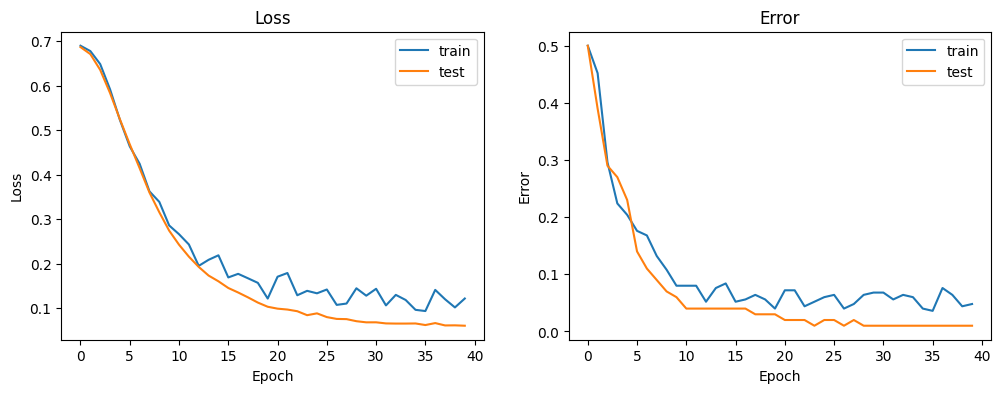

In [7]:
loader = make_data_loader(train=True)

stats = []

model.train()
print(f"Training model with {human_format(sum(p.numel() for p in model.parameters() if p.requires_grad))} parameters")

for epoch in range(40):
    model.train()

    total_loss = 0.
    total_error = 0.
    for bag in loader:
        bag = device(bag)
        y = bag.bag_label

        optimizer.zero_grad()

        # Calculate loss and metrics
        y_pred = model(bag).squeeze()
        loss = loss_function(y_pred, y)

        error = 1. - ((y_pred > .5).float() == y).cpu().detach().float()
        total_error += error
        
        # Backward pass
        loss.backward()

        total_loss += loss.detach().cpu()
        # Step
        optimizer.step()
    
    test_loss, test_error, _ = test_loss_and_error(model, test_loader)

    stats.append({
        "epoch": epoch,
        "loss": total_loss / len(loader),
        "error": total_error / len(loader),
        "test_loss": test_loss,
        "test_error": test_error
    })
    print(
        f"Epoch: {epoch:3d}, loss: {total_loss/len(loader):.4f}, error: {total_error/len(loader):.4f}, test_loss: {test_loss:.4f}, test_error: {test_error:.4f}")

# Plot training and test loss/error
stats = pd.DataFrame(stats)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Loss")
plt.plot(stats["epoch"], stats["loss"], label="train")
plt.plot(stats["epoch"], stats["test_loss"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
plt.title("Error")
plt.plot(stats["epoch"], stats["error"], label="train")
plt.plot(stats["epoch"], stats["test_error"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()

## Test

In [9]:
test_loss, test_error, predictions = test_loss_and_error(model, test_loader)
print(f"Test loss: {test_loss:.4f}, test error: {test_error:.4f}")

print_prediction_stats(predictions, target_numbers=TARGET_NUMBERS)

Test loss: 0.0611, test error: 0.0100

                                 % acc    total    -pred    +pred     example
  bags                              99      100       49       51     0 8 3 2 9 1 7
  bags with 0s                      98       83       32       51     0 8 3 2 9 1 7
  bags without 0s                  100       17       17        0     2 8 5 6 8 3 7 6
  bags with 0s and 1s               98       70       19       51     0 8 3 2 9 1 7
  bags with 0s and not 1s          100       13       13        0     6 6 8 3 0 3 6 6 9 4
  bags with 1s                      98       80       29       51     0 8 3 2 9 1 7
  bags without 1s                  100       20       20        0     2 8 5 6 8 3 7 6
  bags with 1s and 0s               98       70       19       51     0 8 3 2 9 1 7
  bags with 1s and not 0s          100       10       10        0     2 2 7 4 1 6 9 5 5 8 6
  bags with 2 key instance(s)      100       46        0       46     0 0 5 8 2 1 9 2 0 6 5
  bags with 3 key

### First 10 bags in test dataset

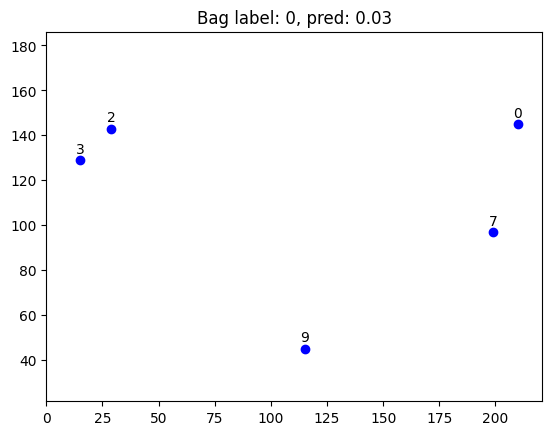

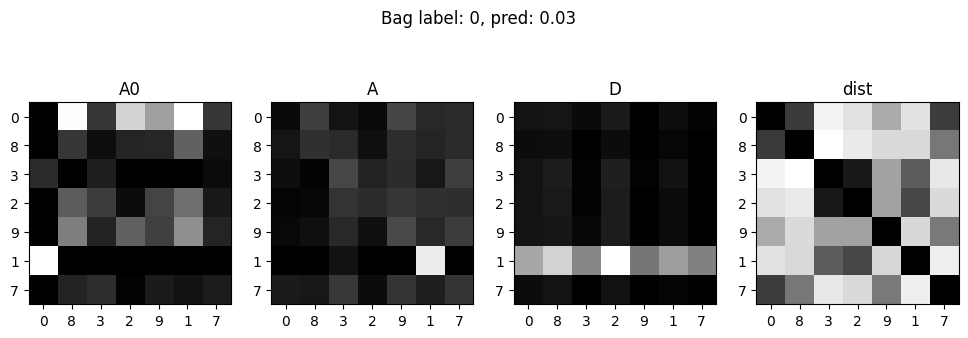

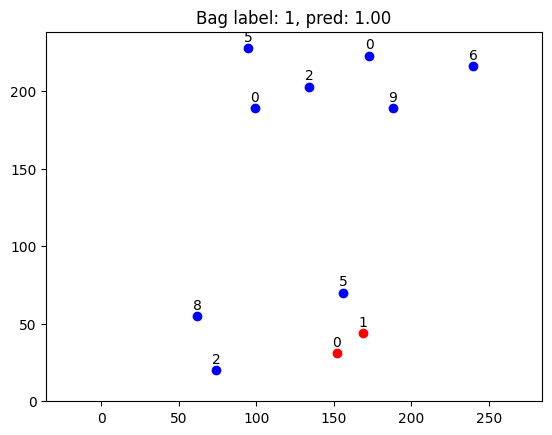

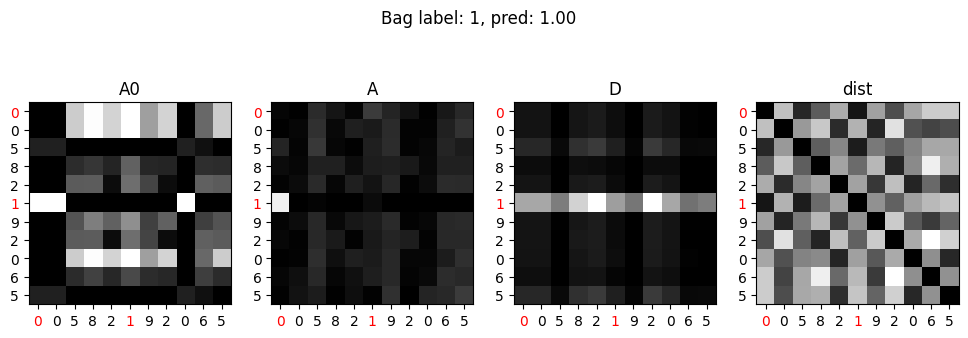

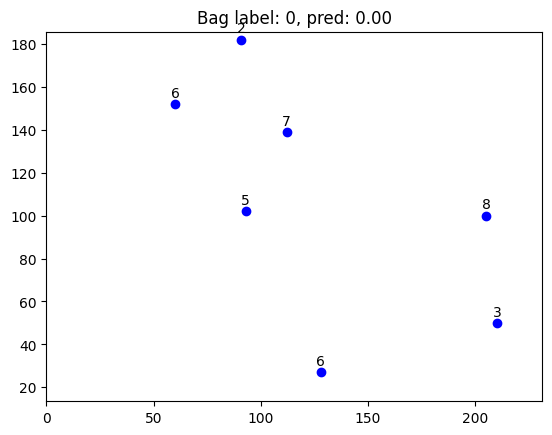

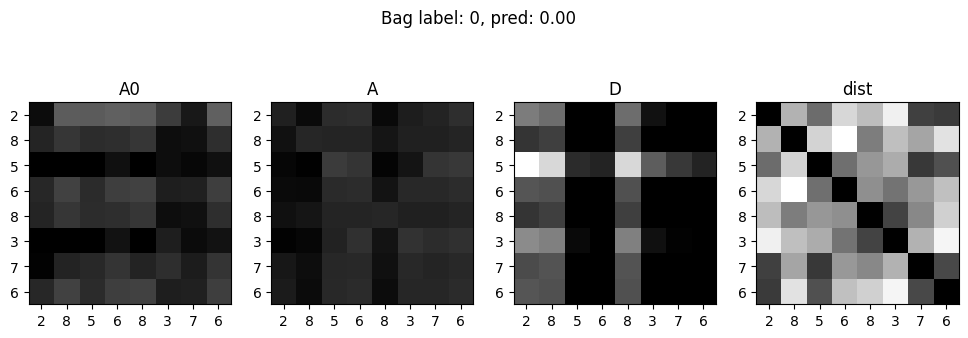

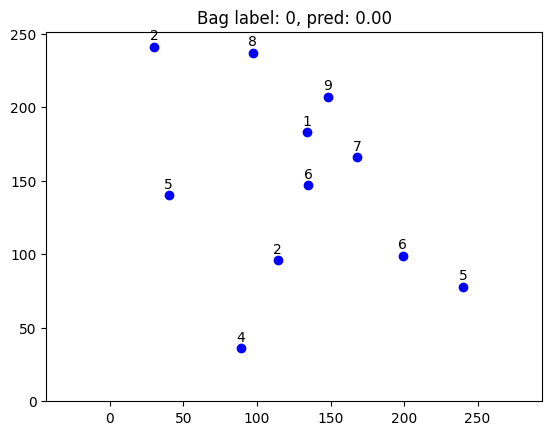

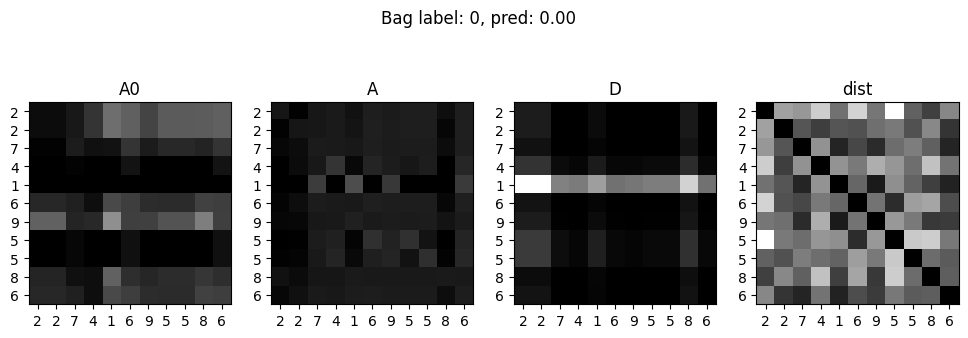

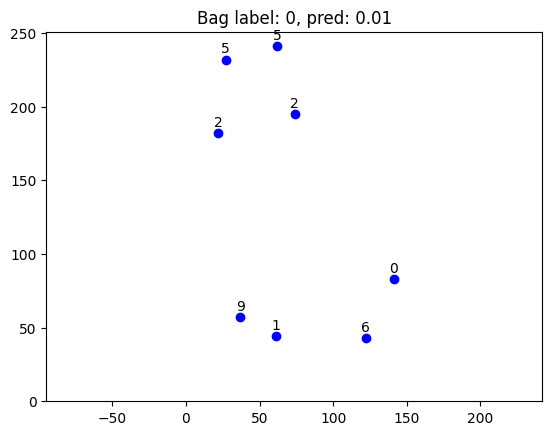

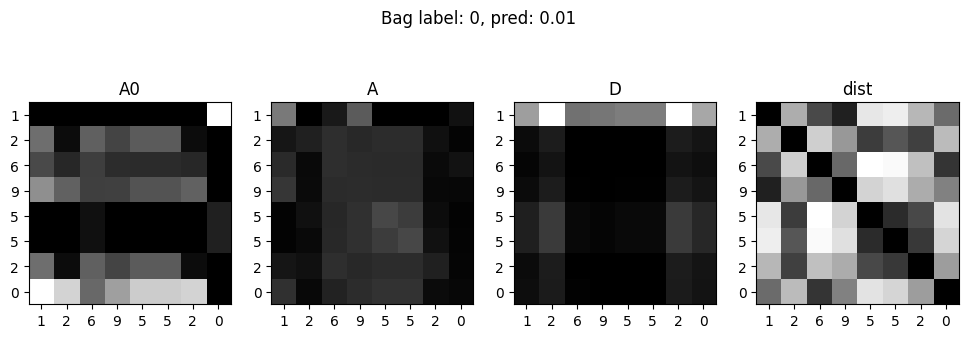

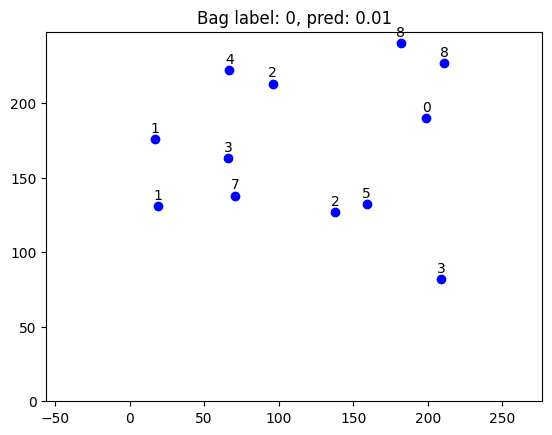

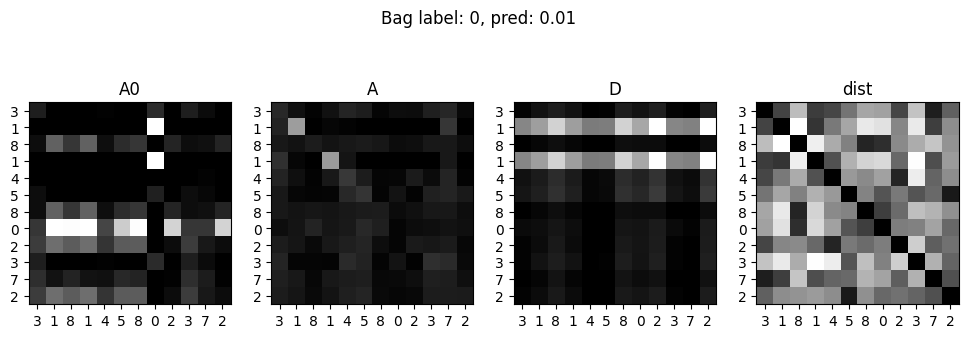

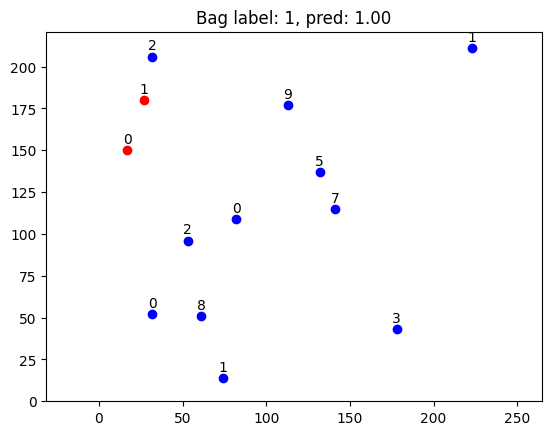

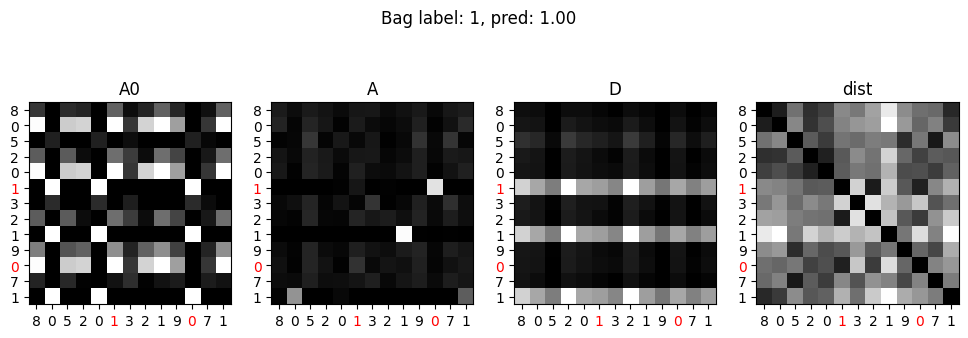

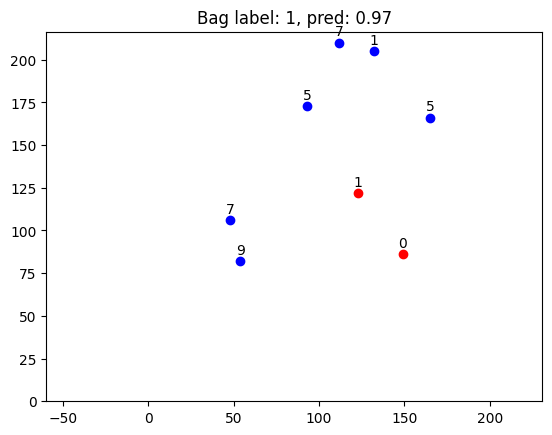

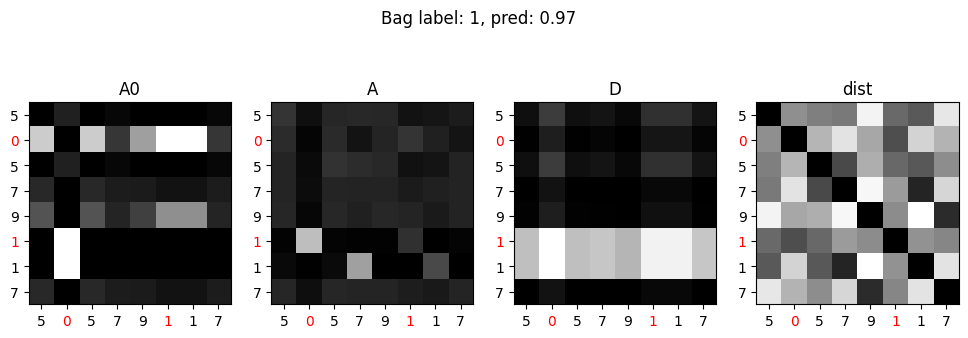

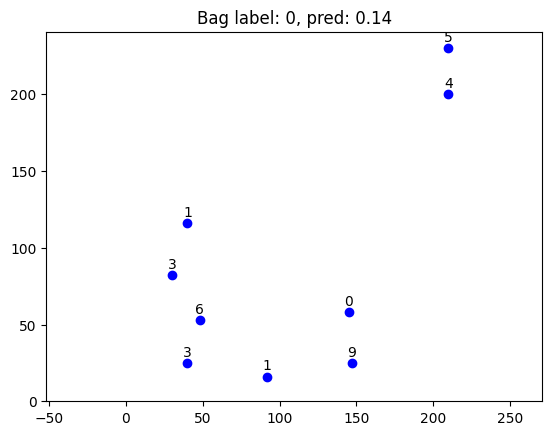

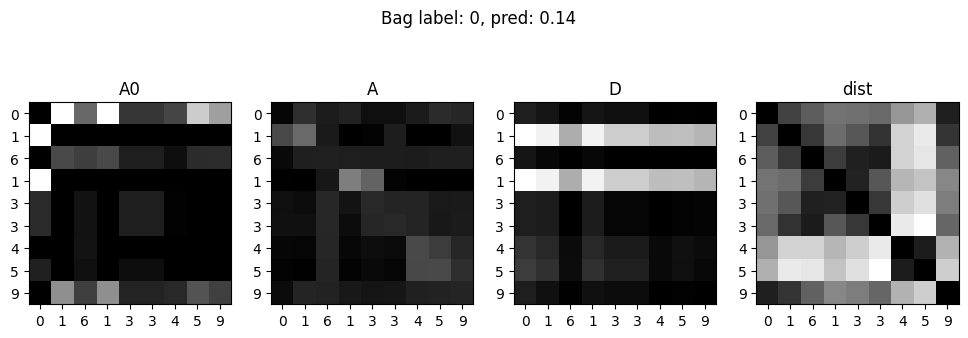

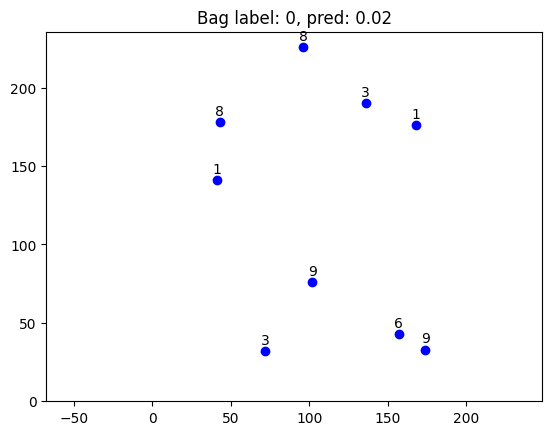

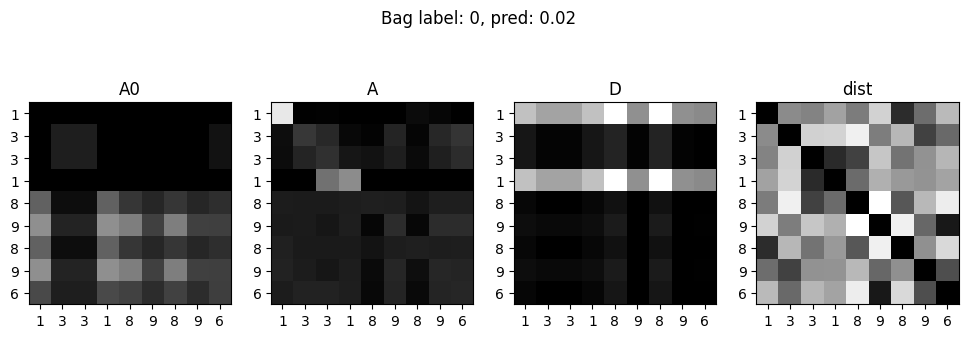

In [10]:
def visualize_prediction(bag, y_pred):
    y = bag.bag_label
    if DATASET == OneHotMNISTBags:
        if isinstance(attention_layer, WeightedAverageAttention):
            print_one_hot_bag_with_attention(bag, attention_layer.A, y_pred>.5)
            print()
        elif isinstance(attention_layer, MultiHeadAttention):
            plt.figure()
            plot_attention_head(bag, attention_layer.A[0])
            plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        else:
            print_one_hot_bag(bag, y_pred>.5)
    elif DATASET == MNISTBags:
        if isinstance(attention_layer, WeightedAverageAttention):
            plot_bag(bag, y_pred=y_pred, attention=attention_layer.A.squeeze(-1))
        elif isinstance(attention_layer, MultiHeadAttention):
            plot_bag(bag, y_pred=y_pred)
            plt.figure()
            plot_attention_head(bag, attention_layer.A[0])
            plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        else:
            plot_bag(bag, y_pred=y_pred)
    elif DATASET == OneHotMNISTCollage:
        plt.figure()
        plot_one_hot_collage(bag, y_pred=y_pred)
        plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        if isinstance(attention_layer, DistanceAwareAttentionHead):
            plt.figure(figsize=(12, 4))
            plt.suptitle(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
            plt.subplot(141)
            plt.title("A0")
            plot_attention_head(bag, attention_layer.A0)
            plt.subplot(142)
            plt.title("A")
            plot_attention_head(bag, attention_layer.A)
            plt.subplot(143)
            plt.title("D")
            plot_attention_head(bag, attention_layer.D, limit_range=False)
            plt.subplot(144)
            plt.title("dist")
            plot_attention_head(bag, attention_layer.dist, limit_range=False)

# Visualize first 10 bags
model.eval()
with torch.no_grad():
    for bag in itertools.islice(test_loader, 10):
        bag = device(bag)
        y = bag.bag_label.float()
        y_pred = model(bag).squeeze(0)
        visualize_prediction(bag, y_pred)

### First 10 mistakes in test dataset

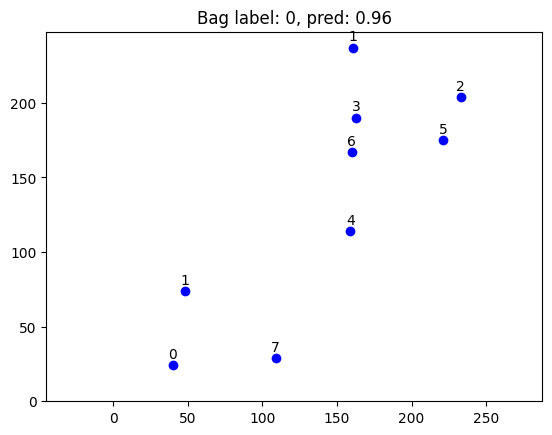

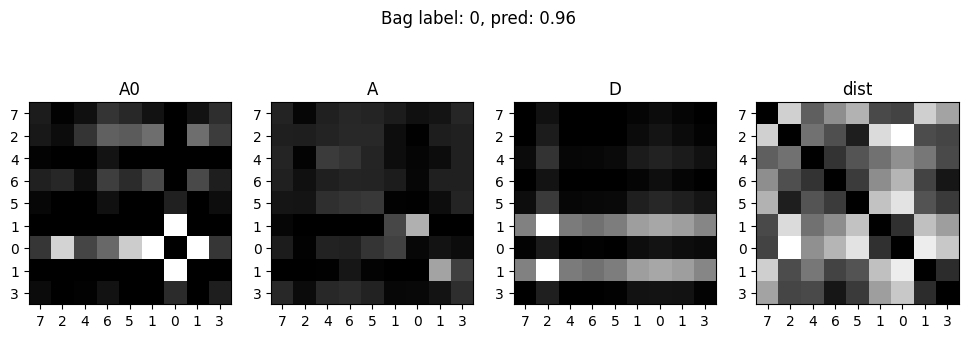

In [11]:
# Visualize first 10 mistakes
model.eval()
with torch.no_grad():
    i = 0
    for bag in test_loader:
        if i == 10:
            break
        bag = device(bag)
        y = bag.bag_label.float()
        y_pred = model(bag).squeeze(0)
        if ((y_pred > .5).float() != y).cpu().detach():
            visualize_prediction(bag, y_pred)
            i += 1